# Fast Style Transfer for Arbitrary Styles + Tensor Flow Lite

Neural Style Transfer uses deep learning to compose one image in the style of another image. **Fast Style Transfer** is a faster and better implementation of Neural Style that combines the description of one image with the style of another image through convolutional neural networks.



# Import **tensorflow** library

Import library and alias it:

In [ ]:
import tensorflow as tf

# GPU Hardware Accelerator

To vastly speed up processing, we can use the GPU available from the Google Colab cloud service. Colab provides a free Tesla K80 GPU of about 12 GB. It’s very easy to enable the GPU in a Colab notebook:

1.	click **Runtime** in the top left menu
2.	click **Change runtime** type from the drop-down menu
3.	choose **GPU** from the Hardware accelerator drop-down menu
4.	click **SAVE**

Verify that GPU is available:

In [ ]:
tf.__version__, tf.test.gpu_device_name()

('2.8.2', '/device:GPU:0')

# Fast Style Transfer Experiment

## Import Requisite Libraries

Import libraries that we need for this notebook:

In [ ]:
from matplotlib import gridspec
import matplotlib.pylab as plt
import numpy as np
import tensorflow_hub as hub
from PIL import Image

## Get Images from Google Drive

Be sure that the images are in the **Colab Notebooks** directory on Google Drive.

Mount Google Drive:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Load and display the style image:

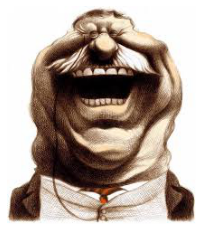

In [ ]:


img_path = 'gdrive/My Drive/_3546/Project/images/teddy.jpeg'
style = Image.open(img_path)
plt.axis('off')
_ = plt.imshow(style)

Get size of style image:

In [ ]:
w, h = style.size
w, h

(209, 241)

Get the image type:

In [ ]:
type(style)

PIL.JpegImagePlugin.JpegImageFile

The image is a PIL image.

Load and display the content image:

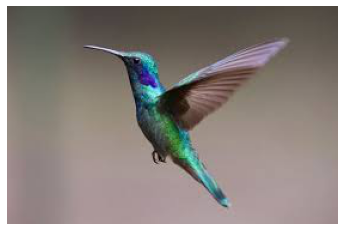

In [ ]:
#img_path = 'gdrive/My Drive/Colab Notebooks/images/'\
#  'humming_bird.jpeg'

img_path = 'gdrive/My Drive/_3546/Project/images/'\
  'humming_bird.jpeg'
content  = Image.open(img_path)
plt.axis('off')
_ = plt.imshow(content)

Get size of content image:

In [ ]:
w, h = content.size
w, h

(277, 182)

Get the image type:

In [ ]:
type(content)

PIL.JpegImagePlugin.JpegImageFile

Since both images are PIL images, we must convert them to tensors before we can feed them to the model.

## Preprocess Images

The recommended size for the style image is 256 x 256 because this is the size expected by the pre-trained style transfer network we use for this experiment. The content image can be any size.

Convert the style image to a NumPy array:

In [ ]:
style_array = tf.keras.preprocessing.image.img_to_array(
    style) / 255.
style_array.shape

(241, 209, 3)

A PIL image is not TensorFlow consumable. So we convert it to a NumPy array and scale it.

Resize the style tensor for the style transfer network:

In [ ]:
style_img = tf.image.resize(style_array, (256, 256))
style_img.shape

TensorShape([256, 256, 3])

Voilà. Convert the content image to a NumPy array:

In [ ]:
content_img = tf.keras.preprocessing.image.img_to_array(
    content) / 255.
content_img.shape

(182, 277, 3)

We did not resize the content image because it can be any size.

## Display Processed Images

Create a function to display images:

In [ ]:
def display_one(img):
  plt.imshow(img)
  plt.axis('off')
  plt.show()

Display the processed style image:

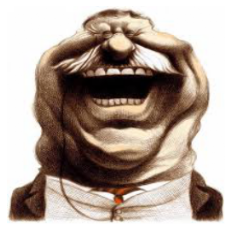

In [ ]:
display_one(style_img)

Display the processed content image:

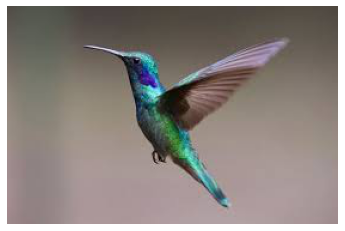

In [ ]:
display_one(content_img)

## Prepare Images for the Network

Content and style images are expected to be 4D Tensors with shapes `[batch_size, image_height, image_width, 3]` by the pre-trained model we use in this experiment. Our content and style images are 3D tensors with shapes `[image_height, image_width, 3]`. So we must add a batch dimension of 1 to make them consumable by the model. We can use the same module to process more images at the same time, but batch size would equal the number of images in this case.

Input and output values of the images are expected to be in the range [0, 1]. We scaled both images to meet this requirement. Shapes of content and style image don't have to match. Output image shape is adapted from the content image shape.

Add the batch dimension:

In [ ]:
style_image = np.expand_dims(style_img, axis=0)
content_image = np.expand_dims(content_img, axis=0)
style_image.shape, content_image.shape

((1, 256, 256, 3), (1, 182, 277, 3))

Convert numpy images to TensorFlow tensors:

In [ ]:
style_tensor = tf.convert_to_tensor(style_image)
content_tensor = tf.convert_to_tensor(content_image)

The style transfer network accepts TensorFlow tensors.

## Load the Model

We use the **arbitrary-image-stylization-v1-256** network. The network is a pre-trained model for fast arbitrary image style transfer. The network doesn't require that images be resized, but prefers that style images are about 256 pixels because it is trained on 256 x 256 pixel images. But content images can be any size.

NST models are normally limited to a pre-selected handful of styles because a separate neural network must be trained for each style image. Arbitrary style transfer mitigates the limitation of basic NST models by using a style network and transformer network. The style network learns how to break down an image into a 100-dimensional vector (or style vector) that represents its style. The transformer network learns how to produce the final stylized image from the style vector and original content image.

The original NST networks requires a slow iterative optimization process that limits its practical application. Fast approximations with feed-forward neural networks are faster, they are tied to a fixed set of styles. So they cannot adapt to arbitrary new styles. The latest fast style networks enable arbitrary style transfer in real-time. So they are referred to as fast style transfer for abritrary styles. At this new network is an adaptive instance normalization (AdaIN) layer that aligns the mean and variance of the content features with those of the style features. The new network achieves speed comparable to the fastest existing approaches without the restriction of a pre-defined set of styles. The approach allows flexible user controls such as content-style trade-off, style interpolation, and color & spatial controls using a single feedforward neural network.

To view the documentation for the arbitrary network, peruse:

https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2

Load the pre-trained style transfer network:

In [ ]:
p1 = 'https://tfhub.dev/google/magenta/'
p2 = 'arbitrary-image-stylization-v1-256/2'
URL = p1 + p2

hub_handle = URL
hub_module = hub.load(hub_handle)

Build the hub module from pre-trained fast arbitrary image style transfer network.

## Demonstrate Image Stylization

Feed the model a content image and style reference image:

In [ ]:
outputs = hub_module(content_tensor, style_tensor)
pastiche = outputs[0]
pastiche.shape

TensorShape([1, 184, 280, 3])

The signature of the hub module for image stylization accepts the processed content image and the processed style reference image to create a stylized image from learning how to blend the two tensors. A **pastiche** is an artistic work in a style that imitates that of another work, artist or period.

Training is fast with the GPU! Training the hub module signature with a CPU takes some time.

## Explore the Stylized Image

Explore the stylized NumPy image:

In [ ]:
pastiche_numpy = tf.squeeze(pastiche).numpy()
pastiche_numpy.shape, content_img.shape

((184, 280, 3), (182, 277, 3))

Convert the new stylized image tensor to NumPy for easy exploration. The shape is not exactly the same as the content image, but very close.

Explore a slice from the stylized image tensor:

In [ ]:
pastiche_numpy[0][0]

array([0.98716754, 0.9901434 , 0.9881897 ], dtype=float32)

As expected, it has the same pixel characteristics as any other image.

Extract matrix components:

In [ ]:
m = pastiche_numpy
r, c, channels = m.shape[0], m.shape[1], m.shape[2]
r, c, channels

(184, 280, 3)

The output image is a 3D matrix consisting of 184 rows, 280 columns, and 3 channels.

Get number of pixels in the matrix:

In [ ]:
pixels = r * c
pixels

51520

So each RGB channel has 51,520 pixels.

Check if RGB channel pixels are scaled:

In [ ]:
red = m[m[:, :, 0] < 1, 0] < 1
green = m[m[:, :, 1] < 1, 0] < 1
blue = m[m[:, :, 2] < 1, 0] < 1
print (len(red), len(green), len(blue))
print (red, green, blue)

51520 51520 51520
[ True  True  True ...  True  True  True] [ True  True  True ...  True  True  True] [ True  True  True ...  True  True  True]


The algorithms check if the pixels in each channel are less than one. Each channel has the expected number of pixels. Since all truth table values aren't displayed, we need one more step:

In [ ]:
all(red), all(green), all(blue)

(True, True, True)

The all() function returns True if all items in an iterable are true, otherwise it returns False. So all pixels are scaled.

We can check if pixels are scaled in one step:

In [ ]:
truth = np.where((m < 1), True, False)
truth.all()

True

We showed the multistep process to provide a glimpse under the hood of the stylized image.

## Visualize

Create a visualization function:

In [ ]:
def show_n(images, titles=('',)):
  n = len(images)
  image_sizes = [image.shape[1] for image in images]
  w = (image_sizes[0] * 6) // 320
  plt.figure(figsize=(w  * n, w))
  gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
  for i in range(n):
    plt.subplot(gs[i])
    plt.imshow(images[i][0], aspect='equal')
    plt.axis('off')
    plt.title(titles[i] if len(titles) > i else '')
  plt.show()

Visualize original content image, style image, and stylized image:

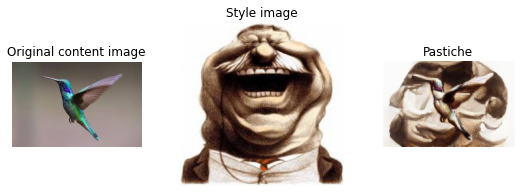

In [ ]:
show_n([content_image, style_image, pastiche],
       titles=['Original content image', 'Style image',
               'Pastiche'])

Create a function to display the new image:

In [ ]:
def display_pastiche(img, size):
  plt.figure(figsize = size)
  plt.imshow(tf.squeeze(img))
  plt.axis('off')
  plt.show()

Display the stylized image:

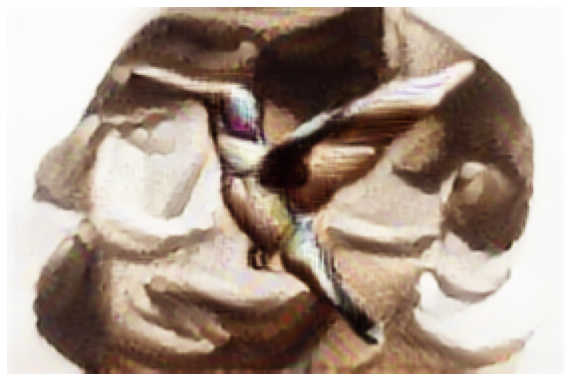

In [ ]:
f_size = (10, 15)
display_pastiche(pastiche, f_size)

## Image Stylization with Multiple Images

Create lists of style reference and content images. Choose one from each list to create a pastiche.

### Get Images

Create a function to grab an image from Google Drive:

In [ ]:
def get_image(img_path):
  return Image.open(img_path)

Grab style images:

In [ ]:
d = 'gdrive/My Drive/Colab Notebooks/images/dali.jpg'
dali = get_image(d)
v = 'gdrive/My Drive/Colab Notebooks/images/van-gogh.jpg'
van_gogh = get_image(v)
m = 'gdrive/My Drive/Colab Notebooks/images/modern.jpg'
modern = get_image(m)
e = 'gdrive/My Drive/Colab Notebooks/images/escher.jpeg'
escher = get_image(e)
pic = 'gdrive/My Drive/Colab Notebooks/images/picasso.jpg'
picasso = get_image(pic)
p = 'gdrive/My Drive/Colab Notebooks/images/pollock.jpg'
pollock = get_image(p)
mon = 'gdrive/My Drive/Colab Notebooks/images/monet.jpg'
monet = get_image(mon)

Display style reference images sizes:

In [ ]:
d = 'gdrive/My Drive/_3546/Project/images/dali.jpg'
dali = get_image(d)
v = 'gdrive/My Drive/_3546/Project/images/vincent-van-gogh.jpg'
van_gogh = get_image(v)
m = 'gdrive/My Drive/_3546/Project/images/modern.jpg'
modern = get_image(m)
e = 'gdrive/My Drive/_3546/Project/images/escher.jpeg'
escher = get_image(e)
pic = 'gdrive/My Drive/_3546/Project/images/picasso.jpg'
picasso = get_image(pic)
p = 'gdrive/My Drive/_3546/Project/images/pollock.jpg'
pollock = get_image(p)
mon = 'gdrive/My Drive/_3546/Project/images/monet.jpg'
monet = get_image(mon)

In [ ]:
dali.size, van_gogh.size, modern.size, escher.size,\
picasso.size, pollock.size, monet.size

((314, 463),
 (900, 722),
 (2080, 949),
 (262, 193),
 (1656, 2070),
 (612, 408),
 (1500, 1122))

Grab content images:

In [ ]:
t = 'gdrive/My Drive/Colab Notebooks/images/teddy.jpeg'
teddy = get_image(t)
e = 'gdrive/My Drive/Colab Notebooks/images/einstein.jpg'
einstein = get_image(e)
g = 'gdrive/My Drive/Colab Notebooks/images/gem.jpeg'
gem = get_image(g)

Display original content image sizes:

In [ ]:
teddy.size, einstein.size, gem.size

((209, 241), (548, 700), (500, 333))

### Process Images

Create a preprocessing function:

In [ ]:
def preprocess(img, style=True):
  img_array = tf.keras.preprocessing.image.img_to_array(
      img) / 255.
  if style:
    img_array = tf.image.resize(img_array, (256, 256))
  return\
  tf.convert_to_tensor(np.expand_dims(img_array, axis=0))

Process the style images:

In [ ]:
dali_style = preprocess(dali)
van_gogh_style = preprocess(van_gogh)
modern_style = preprocess(modern)
escher_style = preprocess(escher)
picasso_style = preprocess(picasso)
pollock_style = preprocess(pollock)
monet_style = preprocess(monet)

dali_style.shape, van_gogh_style.shape, modern_style.shape,\
escher_style.shape, picasso_style.shape, pollock_style.shape,\
monet_style.shape

(TensorShape([1, 256, 256, 3]),
 TensorShape([1, 256, 256, 3]),
 TensorShape([1, 256, 256, 3]),
 TensorShape([1, 256, 256, 3]),
 TensorShape([1, 256, 256, 3]),
 TensorShape([1, 256, 256, 3]),
 TensorShape([1, 256, 256, 3]))

Process the content images:

In [ ]:
einstein_content = preprocess(einstein, False)
teddy_content = preprocess(teddy, False)
gem_content = preprocess(gem, False)
einstein_content.shape, teddy_content.shape, gem_content.shape

(TensorShape([1, 700, 548, 3]),
 TensorShape([1, 241, 209, 3]),
 TensorShape([1, 333, 500, 3]))

### Visualize Processed Images

Place images in lists:

In [ ]:
styles = [dali_style, van_gogh_style, modern_style,
          escher_style, picasso_style, pollock_style,
          monet_style]
contents = [einstein_content, teddy_content, gem_content]

Create a function to display tensors:

In [ ]:
def display_tensors(imgs, r, c):
  _, axs = plt.subplots(r, c, figsize=(12, 12))
  axs = axs.flatten()
  for img, ax in zip(imgs, axs):
    ax.imshow(tf.squeeze(img))
    ax.axis('off')
  plt.show()

Display style tensors:

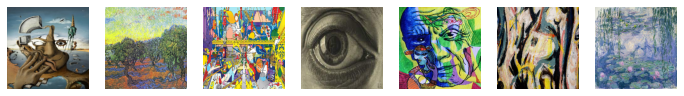

In [ ]:
rows, cols = 1, 7
display_tensors(styles, rows, cols)

Display content tensors:

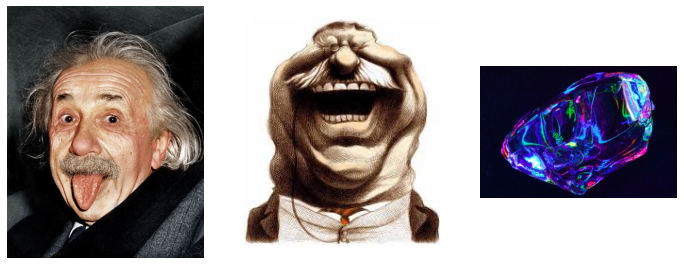

In [ ]:
rows, cols = 1, 3
display_tensors(contents, rows, cols)

### Create Reference Dictionaries

Create a dictionary to represent style tensors:

In [ ]:
style_names = {'dali' : styles[0],
               'van_gogh' : styles[1],
               'modern' : styles[2],
               'escher' : styles[3],
               'picasso' : styles[4],
               'pollock' : styles[5],
               'monet' : styles[6]}

Create a dictionary to represent content tensors:

In [ ]:
content_names = {'einstein' : contents[0],
                 'teddy' : contents[1],
                 'gem' : contents[2]}

### Create Stylized Images

Create a function that creates a pastiche:

In [ ]:
def create(c, s):
  content_im = content_names[c]
  style_im = style_names[s]
  outputs = hub_module(content_im, style_im)
  return content_im, style_im, outputs[0]

Create and display a pastiche:

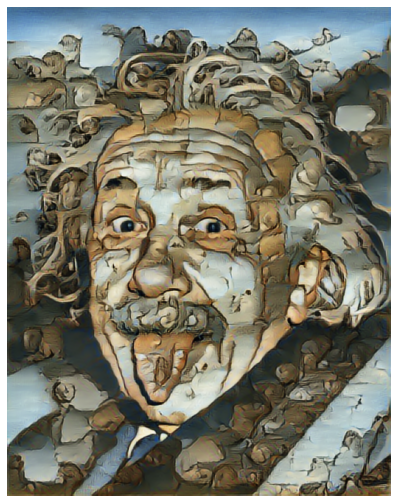

In [ ]:
content, style = 'einstein', 'dali'
content_im, style_im, sim = create(content, style)

f_size = (7, 9)
display_pastiche(sim, f_size)

Feed the function a content and style reference image.

Place images in a list for visualization:

In [ ]:
imgs = [content_im, style_im, sim]

Display the original content and style reference images along with the pastiche.

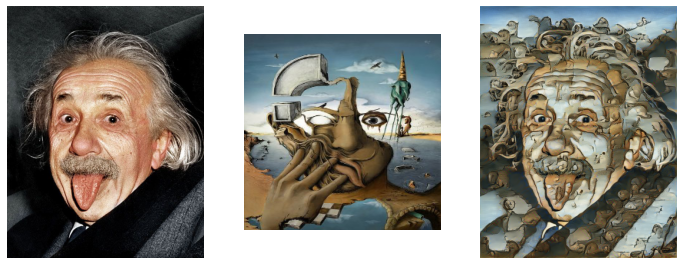

In [ ]:
display_tensors(imgs, 1, 3)

Try one with Teddy Roosevelt:

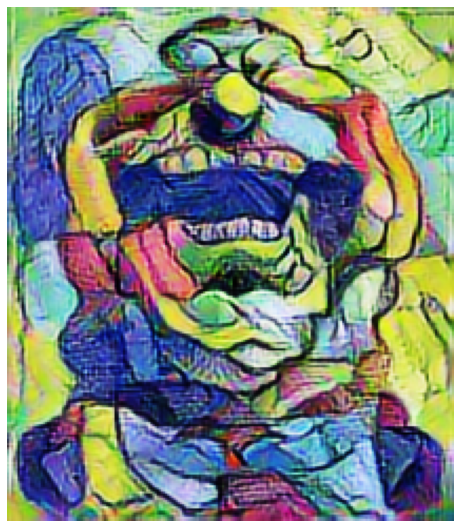

In [ ]:
content, style = 'teddy', 'picasso'
content_im, style_im, sim = create(content, style)

f_size = (8, 10)
display_pastiche(sim, f_size)

Display tensors:

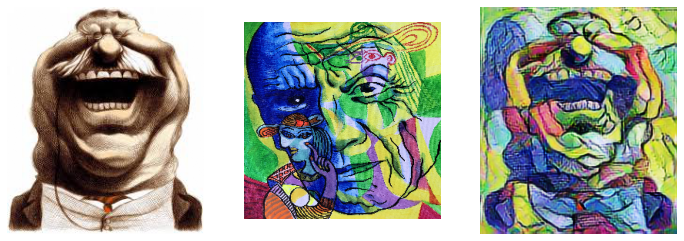

In [ ]:
imgs = [content_im, style_im, sim]
display_tensors(imgs, 1, 3)

Try one with the gem:

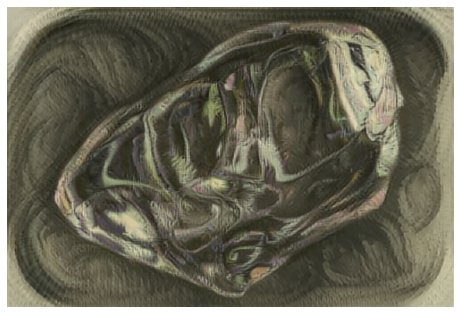

In [ ]:
content, style = 'gem', 'escher'
content_im, style_im, sim = create(content, style)

f_size = (8, 10)
display_pastiche(sim, f_size)

Display tensors:

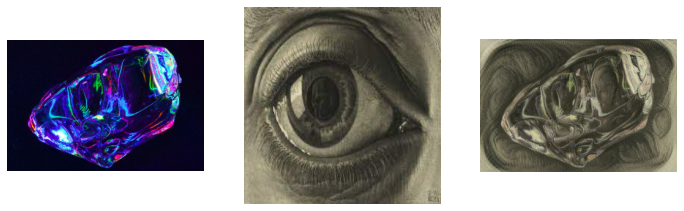

In [ ]:
imgs = [content_im, style_im, sim]
display_tensors(imgs, 1, 3)

# Stylize Images with TensorFlow Lite

**TensorFlow Lite** is an open-source deep learning framework to run TensorFlow models on-device. On-Device Portals (ODPs) allow mobile phone users to easily browse, purchase, and use mobile content and services. An ODP platform enables operators to provide a consistent and branded on-device experience across a large portfolio of services. TensorFlow Lite provides an ODP platform to experiment with and deploy deep learning experiments on their phone.

To get started with TensorFlow Lite on your device, peruse:

https://www.tensorflow.org/lite/examples

We run the experiment in a Colab notebook on a PC. The reason is that on-device RAM is not equal to what we have on our PC. So TensorFlow Lite was developed with on-device limitations (and benefits) in mind.

For an excellent site for on-device TensorFlow Lite, peruse:

https://www.tensorflow.org/lite/examples/style_transfer/overview

TensorFlow Lite is a serious on-device product. So you have to install the appropriate app for your specific device.

## Architecture for a Pre-Trained TensorFlow Lite Model

Content images are exactly the same as what we have already worked with in the first experiment. Style images begin the same but are transformed (or bottlenecked) into `100-dimensional` style bottleneck vectors before being fed into the style transform model.

The atistic style transfer model consists of two submodels - Style Prediciton Model and Style Transform Model. The **Style Prediction Model** is a pre-trained MobilenetV2-based neural network that takes an input style image and transformes it into a `100-dimensional` style bottleneck vector. The **Style Transform Model** is a neural network that applies a style bottleneck vector to a content image to create a pastiche.

## Prepare Images

Images are already processed. But we must prepare the style image for the Style Prediction Model and the content image for the Style Transform model.

Import a requisite library for display:

In [ ]:
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

The mpl parameters set the display size for all images for the rest of the notebook.

Get a content image:

In [ ]:
content_cd = content_names['einstein']
content_cd.shape

TensorShape([1, 700, 548, 3])

The Style Transform Model expects a content image of size 384 x 384: 

In [ ]:
dim = [384, 384]
content_lte = tf.image.resize(content_cd, dim)
content_lte.shape

TensorShape([1, 384, 384, 3])

Centrally crop the content image:

In [ ]:
content_lite = tf.image.resize_with_crop_or_pad(
    content_lte, dim[0], dim[1])
content_lite.shape

TensorShape([1, 384, 384, 3])

Cropping is one of the most basic data augmentation processes for images. The idea is to remove unwanted or irrelevant noise from the periphery of an image, change its aspect ratio, or improve its overall composition.

Get a style image:

In [ ]:
style_lte = style_names['modern']
style_lte.shape

TensorShape([1, 256, 256, 3])

Centrally crop the style image:

In [ ]:
dim = [256, 256]
style_lite = tf.image.resize_with_crop_or_pad(
    style_lte, dim[0], dim[1])
style_lite.shape

TensorShape([1, 256, 256, 3])

## Display Prepared Images

Create a display function:

In [ ]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)
  plt.axis('off')    
  plt.imshow(image)
  if title:
    plt.title(title)

Display content and style images:

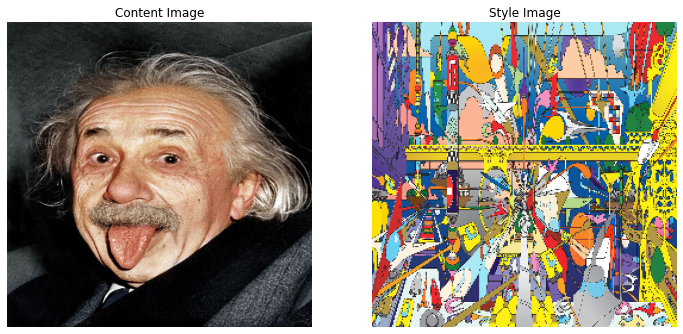

In [ ]:
plt.subplot(1, 2, 1)
imshow(content_lite, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_lite, 'Style Image')

## Create the Style Prediction Model

Create a function for the Style Prediction Model:

In [ ]:
def run_style_predict(processed_style_image):
  # load the model
  interpreter = tf.lite.Interpreter(
      model_path=style_predict_path)
  # set model input
  interpreter.allocate_tensors()
  input_details = interpreter.get_input_details()
  interpreter.set_tensor(
      input_details[0]["index"], processed_style_image)
  # calculate style bottleneck
  interpreter.invoke()
  style_bottleneck = interpreter.tensor(
      interpreter.get_output_details()[0]["index"])()
  return style_bottleneck

The function creates a Style Prediction Model to run style prediction on a processed style image. The function begins by loading the style prediction path into the **interpreter** object (tf.lite.Interpreter), which is a TensorFlow Lite pre-trained MobilenetV2-based neural network. The interpreter uses the style_predict_path to create a tflite predicted style. Input to the interpreter model is then set. The function continues by calculating the style bottleneck. The function ends by using the bottleneck calculation and the tflite predicted style to transform the style image into a 100-dimensional style bottleneck vector.

Set the style predict path:

In [ ]:
tflite_predict = 'style_predict.tflite'
p1 = 'https://tfhub.dev/google/lite-model/magenta/'
p2 = 'arbitrary-image-stylization-v1-256/'
p3 = 'int8/prediction/1?lite-format=tflite'
URL = p1 + p2 + p3

style_predict_path = tf.keras.utils.get_file(
    tflite_predict, URL)

2842624/2828838 [==============================] - 0s 0us/step


Transform the style image into a 100-dimensional style bottleneck vector:

In [ ]:
style_bottleneck = run_style_predict(style_lite)
print('style bottleneck vector shape:',
      style_bottleneck.shape)

style bottleneck vector shape: (1, 1, 1, 100)


## Create the Style Transform Model

Create a function for the Style Transform Model:

In [ ]:
def run_style_transform(
    style_bottleneck, processed_content_image):
  # load the model
  interpreter = tf.lite.Interpreter(
      model_path=style_transform_path)
  # set model input
  input_details = interpreter.get_input_details()
  interpreter.allocate_tensors()
  # set content and style bottleneck
  interpreter.set_tensor(
      input_details[0]["index"], processed_content_image)
  interpreter.set_tensor(
      input_details[1]["index"], style_bottleneck)
  interpreter.invoke()
  # return the transformed content image
  return interpreter.tensor(
      interpreter.get_output_details()[0]["index"])()

The function creates a Style Transform Model that applies a style bottleneck vector to a content image to create a pastiche. The function begins by loading the style transform path into the **interpreter** object (tf.lite.Interpreter). The interpreter uses the style_transform_path to create a tflite transform style. Input to the interpreter model is then set. The function continues by setting the processed content image and style bottleneck for the interpreter. The function ends by returning the transformed content image.

Set the style transform path:

In [ ]:
tflite_transform= 'style_transform.tflite'
p1 = 'https://tfhub.dev/google/lite-model/magenta/'
p2 = 'arbitrary-image-stylization-v1-256/'
p3 = 'int8/transfer/1?lite-format=tflite'
URL = p1 + p2 + p3

style_transform_path = tf.keras.utils.get_file(
    tflite_transform, URL)

294912/284398 [===============================] - 0s 0us/step


## Create the Pastiche

Stylize the content image using the style bottleneck:

In [ ]:
stylized_image = run_style_transform(
    style_bottleneck, content_lite)

Resize the stylized image to the size expected by the TensorFlow Lite pre-trained model:

In [ ]:
pastiche = tf.image.resize(stylized_image, [384, 384])
pastiche.shape

TensorShape([1, 384, 384, 3])

Visualize the pastiche:

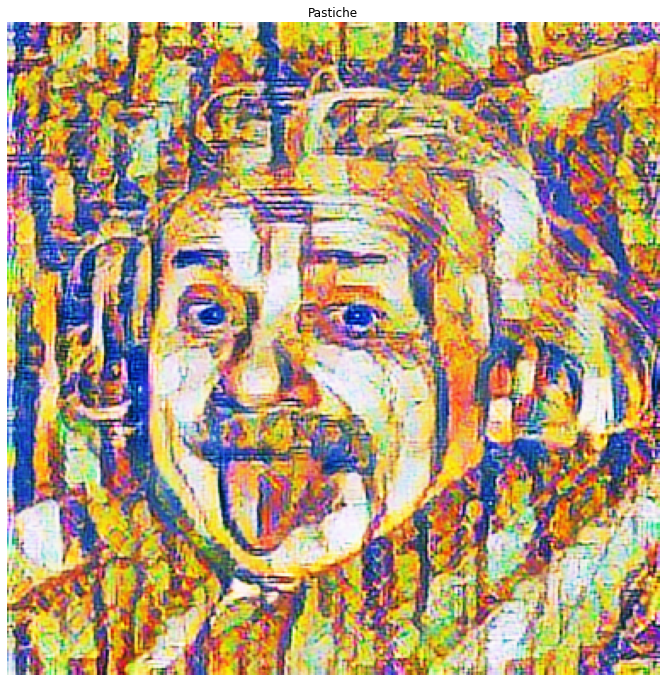

In [ ]:
imshow(pastiche, 'Pastiche')

## Style Blending

By blending the style of the content image into the stylized output, we make the pastiche look more like the content image.

### Prepare the Content Image

Reshape the content image for consumption by the Style Prediction Model:

In [ ]:
dim = [256, 256]
content_blend = tf.image.resize_with_crop_or_pad(
    content_lite, dim[0], dim[1])
content_blend.shape

TensorShape([1, 256, 256, 3])

Transform the reshaped content image into a 100-dimensional style bottleneck vector:

In [ ]:
style_bottleneck_content = run_style_predict(
    content_blend)
style_bottleneck_content.shape

(1, 1, 1, 100)

### Blend the Style Bottleneck Vectors

Blend the style bottleneck vector with the content bottleneck vector.

Define the content blending ratio between 0 and 1:

In [ ]:
content_blending_ratio = 0.5

The range of blending the content image to the pastiche is from 0% to 100%. To extract no style from the content image, assign 0%. To extract all of the style from the content image, assign 100%. Ideally, assign a reasonable percent of style extraction from the content image to get a reasonably blended image.

Create a blended style bottleneck vector from the style bottlenec and content-style bottleneck vectors:

In [ ]:
style_bottleneck_blended =\
  content_blending_ratio * style_bottleneck_content +\
  (1 - content_blending_ratio) * style_bottleneck

Stylize the content image using the style bottleneck:

In [ ]:
stylized_image_blended = run_style_transform(
    style_bottleneck_blended, content_lite)

Visualize the pastiche:

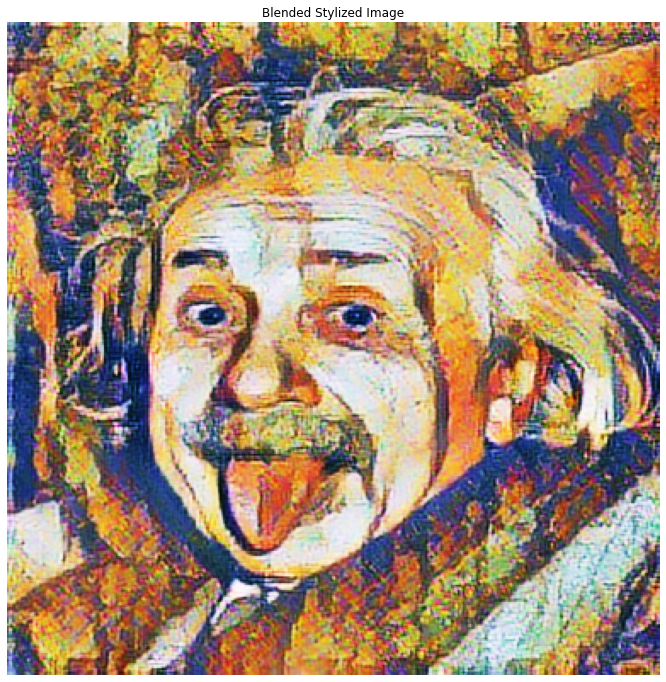

In [ ]:
imshow(stylized_image_blended, 'Blended Stylized Image')

### Save the Pastiche

Save the pastiche to a local drive.

Create a function to convert a tensor to a PIL image:

In [ ]:
def tensor_to_image(tensor):
  tensor = tensor * 255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor) > 3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return Image.fromarray(tensor)

The function up-scales the scaled tensor and converts it to a NumPy array. It then strips the '1' dimension and returns a PIL image.

Save a file to a local drive:

In [ ]:
from google.colab import files

fn = 'patiche.jpg'
tensor_to_image(stylized_image_blended).save(fn)
files.download(fn)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

END -  FastStyleTransfer